* ### 목차
1. 패키지
 - 패키지 불러오기
2. 데이터 불러오기 및 데이터 전처리   
 - 데이터 불러오기  
 - 결측치 및 수작업 처리    
3. 자연어 처리 
 - 독립변수(X인자) 가공 : 서비스 내역 1 ~ 5번 병합하여 통합 서비스 내역 구축 
 - 정규 표현식 처리 : re.sub()
 - 독립변수 불용어 처리  
4. 데이터 
 - 종속변수(Y인자) 원핫인코딩 : one-hot-encoding
 - 데이터 불균형 처리 : upsampling(minority 한 unique 종속변수 제거의 현실적 어려움으로 모든 종속변수 활용을 위해 최대 unique 종속변수 갯수를 기준으로 단순 upsampling  
 - 데이터 분리(train_test_split)  
 - Tokenizer using keras
 - padding using keras
5. 모델링  
 - 평가(F1-Score,AUC,MCC)
 - BiLSTM 학습  
 - 학습 결과 확인
 - 예측 결과 확인  

++ alpha  
 - 



#### 1. 패키지

In [1]:
# 패키지 불러오기
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from pathlib import Path

## 영어 자연어처리
import re
#from nltk.corpus import stopwords
#nltk.download() #본 과정을 통해 다양한 패키지 선택하여 다운로드 가능

## 한글 자연어처리 
from konlpy.tag import Okt

## 데이터
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 모델링
from tensorflow.keras.layers import Bidirectional, LSTM, Embedding, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder
import joblib
from tensorflow import random

import tensorflow as tf
import random as rn

seed_num = 42
np.random.seed(seed_num)
rn.seed(seed_num)
random.set_seed(seed_num)

from keras import backend as K
# CPU 설정 방법
tf.config.set_visible_devices([], 'GPU')
K.set_session(tf.config.set_visible_devices([], 'GPU'))

In [2]:
# 데이터 수작업 처리
def handmade_transfer(dataset,target,transfer):
    
    target = dataset[dataset['핵심어_modified2'] == target].index
    for i in range(len(target)):
        dataset.loc[target[i],'핵심어_modified2'] = transfer
    
    return dataset


# 자연어 처리
def regular_expression(dataset):
    
    # 독립변수(X인자) 가공 : 서비스 내역 1 ~ 5번 병합하여 통합 서비스 내역 구축
    cols = ['서비스내역1', '서비스내역2', '서비스내역3', '서비스내역4','서비스내역5']
    dataset['통합서비스내역'] = dataset[cols].fillna('').apply(lambda row: ' '.join(row.values.astype(str)),axis=1)

    # 정규식 표현 및 불용어 제거
    temp_dataset = copy.deepcopy(dataset)
    temp_dataset['통합서비스내역_clean'] = np.nan
    
    for i in range(len(temp_dataset)):
        # 정규 표현식 처리 : re.sub()
        re_sub = temp_dataset.iloc[i,:]['통합서비스내역']
        temp_dataset.iloc[i,-1] = re.sub('[^a-zA-Z가-힣]',' ',re_sub) # 영어 소문자,대문자,한글 # 숫자 제외

        # capital word transformer
        capital_word = temp_dataset.iloc[i,:]['통합서비스내역_clean']
        temp_dataset.iloc[i,-1] = capital_word.upper()
        
        # 불용어 제거 
        stop_word = temp_dataset.iloc[i,:]['통합서비스내역_clean']
        temp_dataset.iloc[i,-1] = stop_word.replace('있','').replace('하','').replace('것','').replace('들','').replace('그','').replace('및','').replace('되','').replace('보','').replace('않','').replace('나','').replace('됨','').replace('외','')             
                            
        
        temp_dataset.iloc[i,-1] = str(temp_dataset.iloc[i,:]['통합서비스내역_clean'])

    return temp_dataset


#dataset = original_dataset
def core_word_data_upsampling(dataset):
    
    DATA_SET = copy.deepcopy(dataset)
    
    DATA_SET = DATA_SET[['통합서비스내역_clean','핵심어_modified2']]
    X = DATA_SET['통합서비스내역_clean']
    y = DATA_SET['핵심어_modified2']
    
    X = np.array(X).reshape(len(X),1)
    y = np.array(y)

    oversample = RandomOverSampler(sampling_strategy='minority')
    X_over, y_over = oversample.fit_resample(X, y)
    
    for i in range(len(Counter(y))):
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(X_over, y_over)
        
    return(X_over,y_over)

#### 코드 돌리기

In [5]:
#[1] 데이터 불러오기
original_dataset = pd.read_csv('./data/CS_labeling/check_ver3_total.csv')


#[2] 결측치 및 수작업 처리

print('=' * 25+'<결측치 처리>'+'=' * 25)
temp_total_data_count = len(original_dataset['핵심어_modified2'])
print('전체 데이터 갯수 :',temp_total_data_count)

temp_missing_data_count = original_dataset['핵심어_modified2'].isnull().sum()
print('핵심어의 결측치 갯수 :',temp_missing_data_count)

remove_set = original_dataset[original_dataset['핵심어_modified2'].isnull()].index
original_dataset = original_dataset.drop(remove_set)
print('핵심어 결측치 제거 후 갯수 :',len(original_dataset))

print('=' * 25+'<특이 부분 수작업 수정>'+'=' * 25)

print("핵심어_modified2 유일값 :",original_dataset['핵심어_modified2'].unique())
print("#"*30)
print("핵심어_modified2 유일값 갯수 :",len(original_dataset['핵심어_modified2'].unique()))


# 'B’D' & "B'D" 동일한 정보이기에 하나의 정보로 수정

target_word = original_dataset[original_dataset['핵심어_modified2'] == 'B’D'].index
transfer_word = original_dataset[original_dataset['핵심어_modified2'] == "B'D"].index

print('변경할 단어의 인덱스 정보 :',target_word)
print('변경목표 단어의 인덱스 정보 :',transfer_word)



dataset = original_dataset
target = 'B’D'
transfer = "B'D"

original_dataset = handmade_transfer(dataset,target,transfer)


target_word = original_dataset[original_dataset['핵심어_modified2'] == 'B’D'].index
transfer_word = original_dataset[original_dataset['핵심어_modified2'] == "B'D"].index

print("#"*30)
print('수작업 처리 후 변경할 단어의 인덱스 정보 :',target_word)
print('수작업 처리 후 변경목표 단어의 인덱스 정보 :',transfer_word)

print("수작업 처리 후 핵심어_modified2 유일값 갯수 :",len(original_dataset['핵심어_modified2'].unique()))

#[3] 자연어 처리
dataset = original_dataset

original_dataset = regular_expression(dataset)
original_dataset


#[4] 데이터 불균형 처리


# 데이터 불균형 처리 : upsampling(minority 한 unique 종속변수 제거의 현실적 어려움으로 모든 종속변수 활용을 위해 최대 unique 종속변수 갯수를 기준으로 단순 upsampling

dataset = original_dataset

X_over, y_over = core_word_data_upsampling(dataset)

print('=' * 25+'<불균형 처리전 데이터 갯수>'+'=' * 25)
print("핵심어_modified2 유일값 별 갯수 :",Counter(dataset['핵심어_modified2']))

print('=' * 25+'<불균형 처리후 데이터 갯수>'+'=' * 25)
print("핵심어_modified2 유일값 별 갯수 :",Counter(y_over))


=========================<결측치 처리>=========================
전체 데이터 갯수 : 4274
핵심어의 결측치 갯수 : 5
핵심어 결측치 제거 후 갯수 : 4269
=========================<특이 부분 수작업 수정>=========================
핵심어_modified2 유일값 : ['화재수신설정' '합동전자이관' '프로그램 및 펌웨어' '품질경영이관' '포맷' '기타' '패턴' '통신' '테스트시 정상'
 '출력' '채널' '제품확인 정상' '제품사용설명' '재조립 및 재연결' '원자재' '액정' '수리취소' '수리불가' '선로'
 '리시버' '광모듈' '개봉' 'ZD200' 'ZD' 'XLRJACK' 'WONFER' 'VR' 'VFD' 'VAR' 'USB'
 'UNIT' 'U13' 'U11' 'U107' 'TWEETER' 'TR' 'TRTIP35C' 'TRA1943' 'TR3198'
 'TRC5197' 'TRC3198' 'TR5200' 'TR998' 'TR5197' 'TRC4001' 'TRA2400'
 'TR3200' 'TR7915' 'TRMJE340' 'TRD2058' 'TRD998' 'TRC5200' 'TR1943'
 'TR688' 'TPAD' 'THERMISTOR' 'TERMINAL' 'TER' 'TALK' 'TACK' 'SUB' 'SPRING'
 'SPEAKER' 'SMPS' 'SL' 'SDCARD' 'S/W' 'RESET' 'RES' 'REPORT' 'REMOTE'
 'RELAY' 'REAR' 'RACK' 'R105' 'R42' 'R44' 'R101' 'R522' 'R930' 'Q36' 'Q6'
 'Q218' 'Q30' 'Q962' 'Q423' 'Q601' 'Q15' 'Q705' 'Q401' 'Q402' 'Q321'
 'Q120' 'Q105' 'Q37' 'Q170' 'PT' "PROCESSOR B'D" 'POWER' 'PORT' 'PMC'
 'PCB' 'PAM' 'ON/OF

In [6]:
len(y_over)

123716

In [ ]:

start = datetime.now()

#[1] 데이터 불러오기
original_dataset = pd.read_csv('./data/CS_labeling/check_ver3_total.csv')


#[2] 결측치 및 수작업 처리

print('=' * 25+'<결측치 처리>'+'=' * 25)
temp_total_data_count = len(original_dataset['핵심어_modified2'])
print('전체 데이터 갯수 :',temp_total_data_count)

temp_missing_data_count = original_dataset['핵심어_modified2'].isnull().sum()
print('핵심어의 결측치 갯수 :',temp_missing_data_count)

remove_set = original_dataset[original_dataset['핵심어_modified2'].isnull()].index
original_dataset = original_dataset.drop(remove_set)
print('핵심어 결측치 제거 후 갯수 :',len(original_dataset))

print('=' * 25+'<특이 부분 수작업 수정>'+'=' * 25)

print("핵심어_modified2 유일값 :",original_dataset['핵심어_modified2'].unique())
print("#"*30)
print("핵심어_modified2 유일값 갯수 :",len(original_dataset['핵심어_modified2'].unique()))


# 'B’D' & "B'D" 동일한 정보이기에 하나의 정보로 수정

target_word = original_dataset[original_dataset['핵심어_modified2'] == 'B’D'].index
transfer_word = original_dataset[original_dataset['핵심어_modified2'] == "B'D"].index

print('변경할 단어의 인덱스 정보 :',target_word)
print('변경목표 단어의 인덱스 정보 :',transfer_word)



dataset = original_dataset
target = 'B’D'
transfer = "B'D"

original_dataset = handmade_transfer(dataset,target,transfer)


target_word = original_dataset[original_dataset['핵심어_modified2'] == 'B’D'].index
transfer_word = original_dataset[original_dataset['핵심어_modified2'] == "B'D"].index

print("#"*30)
print('수작업 처리 후 변경할 단어의 인덱스 정보 :',target_word)
print('수작업 처리 후 변경목표 단어의 인덱스 정보 :',transfer_word)

print("수작업 처리 후 핵심어_modified2 유일값 갯수 :",len(original_dataset['핵심어_modified2'].unique()))

#[3] 자연어 처리
dataset = original_dataset

original_dataset = regular_expression(dataset)
original_dataset


#[4] 데이터 불균형 처리


# 데이터 불균형 처리 : upsampling(minority 한 unique 종속변수 제거의 현실적 어려움으로 모든 종속변수 활용을 위해 최대 unique 종속변수 갯수를 기준으로 단순 upsampling

dataset = original_dataset

X_over, y_over = core_word_data_upsampling(dataset)

print('=' * 25+'<불균형 처리전 데이터 갯수>'+'=' * 25)
print("핵심어_modified2 유일값 별 갯수 :",Counter(dataset['핵심어_modified2']))

print('=' * 25+'<불균형 처리후 데이터 갯수>'+'=' * 25)
print("핵심어_modified2 유일값 별 갯수 :",Counter(y_over))


# 종속변수(Y인자) 원핫인코딩 :

y_over_df = pd.DataFrame(y_over)
y_over_df.columns= ['core_word']


enc = OneHotEncoder(sparse=False)
enc.fit(y_over_df[['core_word']])

joblib.dump(enc,'./weight/one_hot_encoding.joblib')

enc = joblib.load('./weight/one_hot_encoding.joblib')

y_over_dumm = enc.transform(y_over_df[['core_word']])

print('=' * 25+'<종속변수(Y인자) 원핫인코딩>'+'=' * 25)


print('종속변수 Shape:', y_over_dumm.shape)


# 데이터 분리(train_test_split)

X_over = pd.DataFrame(X_over).squeeze()

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over_dumm, test_size=0.2, random_state=42, stratify=y_over_dumm)

# Tokenizer using keras 

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

joblib.dump(tokenizer,'./weight/tokenizer.joblib')

tokenizer = joblib.load('./weight/tokenizer.joblib')

X_train_encoded = tokenizer.texts_to_sequences(X_train)

word_to_index = tokenizer.word_index
print('=' * 25+'<Tokenizer_index(빈도수 높은 순으로 정렬됨)>'+'=' * 25)
print(word_to_index)

# 패딩을 위한 토큰인 0번 단어를 고려하여 +1 하여 저장
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

# padding using keras

max_len = max(len(sample) for sample in X_train_encoded) # X_trsin Row 기준 인코딩 값중 가장 길이가 긴 값 
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)

print("훈련 데이터의 크기(shape):", X_train_padded.shape)


#[5] 모델링

embedding_dim = 5 #32
hidden_units = 20 #100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units,dropout=0.5,return_sequences=True)))
model.add(Bidirectional(LSTM(int(hidden_units/2),dropout=0.5)))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC(from_logits=True)])

callbacks = EarlyStopping(monitor='val_loss', patience=2, min_delta=0.01) #0.0001

history = model.fit(X_train_padded, y_train, epochs=15, batch_size=64, validation_split=0.2, callbacks=[callbacks])


# 예측 결과 확인
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)

eveluate_run = model.evaluate(X_test_padded, y_test)

print("\n 테스트 Loss: %.4f" % eveluate_run[0])
print("\n 테스트 Accuracy: %.4f" % eveluate_run[1])

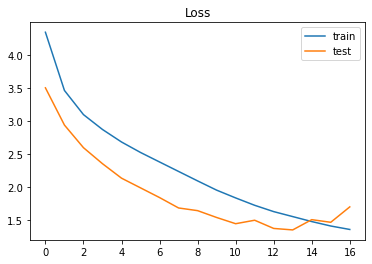

In [48]:
# 학습 결과 확인
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

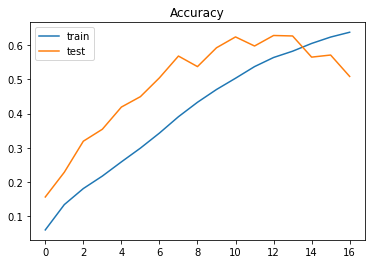

In [49]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Evaluation
* F1-score
* AUC
* MCC

In [54]:
# F1-score

def one_hot_encoding_name():
    one_hot_encoding_list =[]
    for i in range(len(y_over_df[['core_word']].value_counts())):
        select = y_over_df[['core_word']].value_counts().index[i][0]
        one_hot_encoding_list.append(select)
    return one_hot_encoding_list

one_hot_name = one_hot_encoding_name()


import numpy as np

def make_argmax(prediction):
    make_set = np.zeros_like(prediction)
    make_set[np.arange(len(prediction)),pred.argmax(1)] = 1
    return make_set


from sklearn.metrics import multilabel_confusion_matrix,classification_report


def make_f1_score(y_test, prediction, one_hot_name):
    
    argmax_pred = make_argmax(prediction)
    
    with open('./BiLSTM_F1-score.txt','w') as text_file:
        print(classification_report(y_test, argmax_pred, target_names=one_hot_name, digits=3), file=text_file)
    
    return print('BiLSTM_F1-score.txt => OK')


# AUC
from sklearn.metrics import roc_curve,auc

def auc_list(y_test, prediction, one_hot_name):
    fpr = dict()
    tpr = dict()
    threshold = dict()
    roc_auc = dict()
    
    for i in range(y_test.shape[1]): #1
        fpr[i], tpr[i], threshold[i] = roc_curve(y_test[:,i], prediction[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    set_df = pd.DataFrame.from_dict([roc_auc])
    set_df.columns = one_hot_name
    set_df = set_df.T    
    set_df = set_df.round(2)
        
    return set_df,fpr,tpr,threshold,roc_auc



from sklearn.metrics import roc_auc_score

def marco_auc_average(y_test, prediction):
    marco_roc_auc_ovr = roc_auc_score(y_test,prediction, multi_class="ovr",average='macro')
    return marco_roc_auc_ovr




In [55]:
#from sklearn.metrics import precision_score , recall_score , confusion_matrix

from sklearn.metrics import multilabel_confusion_matrix,classification_report
pred = model.predict(X_test_padded)


774/774 [==============================] - 8s 9ms/step


In [56]:
pred

array([[4.68219805e-04, 3.26383852e-05, 3.57955275e-03, ...,
        1.40824877e-05, 7.63307617e-06, 9.68554332e-07],
       [4.50634339e-04, 4.58598294e-07, 3.37652629e-04, ...,
        3.60162426e-06, 6.28443604e-06, 1.33859010e-06],
       [1.57736049e-05, 1.24927055e-06, 5.01642717e-07, ...,
        1.71985405e-07, 1.74360030e-04, 2.41375255e-06],
       ...,
       [5.18060848e-03, 3.11079657e-06, 1.15463219e-03, ...,
        4.63386641e-06, 4.76814836e-04, 4.60607623e-07],
       [2.31217957e-04, 9.80257173e-05, 1.20784715e-02, ...,
        2.68581007e-02, 9.33103536e-07, 7.35300267e-03],
       [2.20910595e-10, 1.81429893e-08, 5.83296633e-10, ...,
        7.58032783e-08, 7.16498619e-07, 3.40045318e-07]], dtype=float32)

In [57]:
pred[0]

array([4.68219805e-04, 3.26383852e-05, 3.57955275e-03, 4.97701392e-03,
       1.17849597e-08, 2.71762037e-05, 1.47595396e-03, 2.73148529e-03,
       1.24869825e-04, 7.87518919e-04, 3.02736316e-06, 3.75051599e-07,
       4.28568342e-07, 2.34762947e-08, 4.34860645e-08, 1.60771609e-08,
       9.29281578e-06, 1.78658453e-07, 8.20371611e-07, 1.56675242e-07,
       2.81469306e-06, 1.29507612e-07, 1.13684784e-07, 1.81332507e-05,
       5.55467494e-08, 1.97571426e-04, 2.08556448e-05, 3.34313372e-03,
       2.96338927e-04, 1.56018592e-03, 8.27409458e-05, 3.93915869e-08,
       2.18538591e-03, 2.30936585e-05, 2.52785074e-04, 4.00963145e-05,
       2.37381705e-08, 6.84705299e-07, 2.03306570e-07, 1.63106573e-09,
       2.06352162e-08, 5.02394251e-08, 2.56388631e-07, 7.84815157e-10,
       8.67098628e-04, 8.86993948e-04, 1.11735998e-08, 2.08927813e-04,
       1.08679046e-07, 5.43421716e-04, 3.06368435e-07, 1.80860329e-02,
       1.67394042e-04, 1.65709503e-06, 4.71785053e-04, 2.87281637e-07,
      

* F1-score

In [69]:
prediction = pred

make_zero = make_argmax(prediction)


print(multilabel_confusion_matrix(y_test, make_zero))

[[[24603    15]
  [   70    56]]

 [[24436   183]
  [    0   125]]

 [[24423   195]
  [   77    49]]

 [[24617     1]
  [  126     0]]

 [[24493   126]
  [  125     0]]

 [[24618     0]
  [  126     0]]

 [[24604    15]
  [   25   100]]

 [[24492   126]
  [  126     0]]

 [[24618     0]
  [  126     0]]

 [[24604    14]
  [   24   102]]

 [[24616     3]
  [    0   125]]

 [[24618     0]
  [    0   126]]

 [[24618     1]
  [   58    67]]

 [[24617     2]
  [    0   125]]

 [[24618     0]
  [  126     0]]

 [[24616     2]
  [    0   126]]

 [[24606    12]
  [    0   126]]

 [[24582    36]
  [    0   126]]

 [[24602    16]
  [    0   126]]

 [[24599    19]
  [    0   126]]

 [[24290   328]
  [    0   126]]

 [[24619     0]
  [    0   125]]

 [[24551    68]
  [    0   125]]

 [[24617     1]
  [  126     0]]

 [[24615     3]
  [    0   126]]

 [[24602    17]
  [    0   125]]

 [[24588    31]
  [   80    45]]

 [[24581    38]
  [  125     0]]

 [[24492   126]
  [  100    26]]

 [[24550    69

In [136]:
multilabel_confusion_matrix(y_test, make_zero)

array([[[24603,    15],
        [   70,    56]],

       [[24436,   183],
        [    0,   125]],

       [[24423,   195],
        [   77,    49]],

       [[24617,     1],
        [  126,     0]],

       [[24493,   126],
        [  125,     0]],

       [[24618,     0],
        [  126,     0]],

       [[24604,    15],
        [   25,   100]],

       [[24492,   126],
        [  126,     0]],

       [[24618,     0],
        [  126,     0]],

       [[24604,    14],
        [   24,   102]],

       [[24616,     3],
        [    0,   125]],

       [[24618,     0],
        [    0,   126]],

       [[24618,     1],
        [   58,    67]],

       [[24617,     2],
        [    0,   125]],

       [[24618,     0],
        [  126,     0]],

       [[24616,     2],
        [    0,   126]],

       [[24606,    12],
        [    0,   126]],

       [[24582,    36],
        [    0,   126]],

       [[24602,    16],
        [    0,   126]],

       [[24599,    19],
        [    0,   126]],



In [120]:
print(classification_report(y_test, make_zero, target_names=one_hot_name, digits=3))

               precision    recall  f1-score   support

         ACDC      0.789     0.444     0.569       126
         REAR      0.406     1.000     0.577       125
       REMOTE      0.201     0.389     0.265       126
       REPORT      0.000     0.000     0.000       126
          RES      0.000     0.000     0.000       125
        RESET      0.000     0.000     0.000       126
          S/W      0.870     0.800     0.833       125
       SDCARD      0.000     0.000     0.000       126
           SL      0.000     0.000     0.000       126
         SMPS      0.879     0.810     0.843       126
      SPEAKER      0.977     1.000     0.988       125
       SPRING      1.000     1.000     1.000       126
          SUB      0.985     0.536     0.694       125
         TACK      0.984     1.000     0.992       125
         TALK      0.000     0.000     0.000       126
          TER      0.984     1.000     0.992       126
     TERMINAL      0.913     1.000     0.955       126
   THERMI

C:\Users\user\anaconda3\envs\inter_m_poc\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
y_test= y_test
prediction= pred
one_hot_name= one_hot_name

make_f1_score(y_test, prediction, one_hot_name)


BiLSTM_F1-score.txt => OK


C:\Users\user\anaconda3\envs\inter_m_poc\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
pred

array([[4.68219805e-04, 3.26383852e-05, 3.57955275e-03, ...,
        1.40824877e-05, 7.63307617e-06, 9.68554332e-07],
       [4.50634339e-04, 4.58598294e-07, 3.37652629e-04, ...,
        3.60162426e-06, 6.28443604e-06, 1.33859010e-06],
       [1.57736049e-05, 1.24927055e-06, 5.01642717e-07, ...,
        1.71985405e-07, 1.74360030e-04, 2.41375255e-06],
       ...,
       [5.18060848e-03, 3.11079657e-06, 1.15463219e-03, ...,
        4.63386641e-06, 4.76814836e-04, 4.60607623e-07],
       [2.31217957e-04, 9.80257173e-05, 1.20784715e-02, ...,
        2.68581007e-02, 9.33103536e-07, 7.35300267e-03],
       [2.20910595e-10, 1.81429893e-08, 5.83296633e-10, ...,
        7.58032783e-08, 7.16498619e-07, 3.40045318e-07]], dtype=float32)

* AUC & AUC average

# 테스트 시작

In [121]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 0, 0, 1, 0])
scores = np.array([0.23, 0.07, 0.35, 0.8, 0.7,0.1])
fpr, tpr, thresholds = metrics.roc_curve(y, scores) #, pos_label=2


In [122]:
fpr

array([0.        , 0.33333333, 0.33333333, 0.66666667, 0.66666667,
       1.        , 1.        ])

In [123]:
tpr

array([0.        , 0.        , 0.33333333, 0.33333333, 0.66666667,
       0.66666667, 1.        ])

In [124]:
thresholds

array([1.8 , 0.8 , 0.7 , 0.35, 0.23, 0.1 , 0.07])

In [125]:
metrics.auc(fpr, tpr)

0.33333333333333337

In [126]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [131]:
enc.inverse_transform(y_test)

array([['TALK'],
       ['CONNECTOR'],
       ['TPAD'],
       ...,
       ['REPORT'],
       ['CD'],
       ['IC101']], dtype=object)

In [127]:
pred

array([[4.68219805e-04, 3.26383852e-05, 3.57955275e-03, ...,
        1.40824877e-05, 7.63307617e-06, 9.68554332e-07],
       [4.50634339e-04, 4.58598294e-07, 3.37652629e-04, ...,
        3.60162426e-06, 6.28443604e-06, 1.33859010e-06],
       [1.57736049e-05, 1.24927055e-06, 5.01642717e-07, ...,
        1.71985405e-07, 1.74360030e-04, 2.41375255e-06],
       ...,
       [5.18060848e-03, 3.11079657e-06, 1.15463219e-03, ...,
        4.63386641e-06, 4.76814836e-04, 4.60607623e-07],
       [2.31217957e-04, 9.80257173e-05, 1.20784715e-02, ...,
        2.68581007e-02, 9.33103536e-07, 7.35300267e-03],
       [2.20910595e-10, 1.81429893e-08, 5.83296633e-10, ...,
        7.58032783e-08, 7.16498619e-07, 3.40045318e-07]], dtype=float32)

In [144]:
pred

array([[4.68219805e-04, 3.26383852e-05, 3.57955275e-03, ...,
        1.40824877e-05, 7.63307617e-06, 9.68554332e-07],
       [4.50634339e-04, 4.58598294e-07, 3.37652629e-04, ...,
        3.60162426e-06, 6.28443604e-06, 1.33859010e-06],
       [1.57736049e-05, 1.24927055e-06, 5.01642717e-07, ...,
        1.71985405e-07, 1.74360030e-04, 2.41375255e-06],
       ...,
       [5.18060848e-03, 3.11079657e-06, 1.15463219e-03, ...,
        4.63386641e-06, 4.76814836e-04, 4.60607623e-07],
       [2.31217957e-04, 9.80257173e-05, 1.20784715e-02, ...,
        2.68581007e-02, 9.33103536e-07, 7.35300267e-03],
       [2.20910595e-10, 1.81429893e-08, 5.83296633e-10, ...,
        7.58032783e-08, 7.16498619e-07, 3.40045318e-07]], dtype=float32)

In [147]:
make_argmax(pred)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [149]:
enc.inverse_transform(make_argmax(pred))

array([['TALK'],
       ['IC9'],
       ['TPAD'],
       ...,
       ['FUSE'],
       ['WONFER'],
       ['U107']], dtype=object)

In [130]:
np.max(pred[0])

0.446365

In [135]:
np.max(pred[0])

0.446365

In [177]:
pred_fun = []
pred_re =[]
real_va =[]

y_test = y_test
pred = pred

real_enc_tran = enc.inverse_transform(y_test).T

pred_enc_tran = enc.inverse_transform(make_argmax(pred)).T

for i in range(len(y_test)):
    pred_fun_list = np.max(pred[i])
    pred_fun.append(pred_fun_list)
    
merge_set = pd.DataFrame([pred_fun,pred_enc_tran])    
#merge_set = pd.DataFrame([merge_set,pd.DataFrame(real_enc_tran).T])  
#merge_set = merge_set.columns(['pred_fun','pred','Real'])

In [178]:
merge_set

,0,1,2,3,4,5,6,7,8,9,...,24734,24735,24736,24737,24738,24739,24740,24741,24742,24743
0,0.446365,0.549342,0.895625,0.157204,0.428052,0.521947,0.203739,0.165238,0.293449,0.825834,...,0.740396,0.255277,0.175796,0.77283,0.255549,0.180614,0.836702,0.116313,0.201011,0.924059
1,"[TALK, IC9, TPAD, POWER, OHM, IC9, MINORITY_IT...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
lable_unique = np.unique(real_enc_tran)

compare_list = []

for i in range(len(lable_unique)):
    for j in range(len(pred_enc_tran)):
        if lable_unique[i] == pred_enc_tran[j]:
            compare_list.append(1)
        else:
            compare_list.append(0)

In [159]:
compare_list

[1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,


In [167]:
np.unique(real_enc_tran)

array(['ACDC', 'ACU', 'ADAPTER', 'AMP', 'ANT', 'ATT', 'AUDIO', "B'D",
       'BALL', 'BATTERY', 'BOTTOM', 'C15000', 'C170', 'C180', 'C266',
       'C32', 'C320', 'C3200', 'C350', 'C40', 'C41', 'C436', 'C5006',
       'C5200', 'C70', 'C720', 'CABLE', 'CAP', 'CASE', 'CD', 'CH', 'COIL',
       'CONDENSER', 'CONNECTOR', 'CONTROL', 'CPU', 'D112', 'D200', 'D216',
       'D5', 'D515', 'D516', 'D6', 'D998', 'DIODE', 'DISPLAY', 'ECS',
       'EM', 'EMERGENCY', 'FAN', 'FET', 'FRONT', 'FUSE', 'G1', 'GBPC',
       'GRILL', 'HOUSING', 'IC', 'IC10', 'IC100', 'IC101', 'IC102',
       'IC103', 'IC3', 'IC4', 'IC403', 'IC4558', 'IC503', 'IC504',
       'IC702', 'IC7820', 'IC7918', 'IC8920', 'IC9', 'ICLM723CN',
       'ICMAX488', 'ICTDA8953', 'IM', 'INPUT', 'JACK', 'KNOB', 'LCD',
       'LED', "MAINB'D", 'MAINPCB', 'MATRIX', 'MCU', 'MECHA', 'MIC',
       'MINORITY_ITEM', 'MUTE', 'OHM', 'OLED', 'ON/OFF', 'PAM', 'PCB',
       'PMC', 'PORT', 'POWER', "PROCESSOR B'D", 'PT', 'Q105', 'Q120',
       'Q15', 'Q17

In [155]:
real_enc_tran

array([['TALK'],
       ['CONNECTOR'],
       ['TPAD'],
       ...,
       ['REPORT'],
       ['CD'],
       ['IC101']], dtype=object)

In [156]:
pred_enc_tran

array([['TALK'],
       ['IC9'],
       ['TPAD'],
       ...,
       ['FUSE'],
       ['WONFER'],
       ['U107']], dtype=object)

In [ ]:
#argmax_pred_test = make_argmax(pred)

y_true = enc.inverse_transform(y_test).flatten()
#y_pred = enc.inverse_transform(argmax_pred).flatten()

In [98]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
X, y = make_multilabel_classification(random_state=0)

clf = MultiOutputClassifier(LogisticRegression()).fit(X, y)

y_pred = clf.predict_proba(X)

y_pred2 = np.transpose([pred[:, 1] for pred in y_pred])

In [99]:
X

array([[3., 1., 4., ..., 4., 1., 3.],
       [5., 0., 6., ..., 0., 0., 3.],
       [3., 4., 1., ..., 3., 2., 5.],
       ...,
       [2., 1., 2., ..., 1., 0., 3.],
       [6., 4., 1., ..., 1., 3., 5.],
       [2., 4., 2., ..., 5., 4., 2.]])

In [100]:
y

array([[0, 0, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 0],
       [1, 1, 1, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 1, 1, 1],
       [1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1],
       [1, 1, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 0, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1],
       [1, 1, 1, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 1, 0, 1, 1],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 0, 1, 0],
       [1, 0, 0, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0,

In [101]:
len(y)

100

In [102]:
y.shape

(100, 5)

In [103]:
y_pred

[array([[0.97174016, 0.02825984],
        [0.93436781, 0.06563219],
        [0.2510522 , 0.7489478 ],
        [0.24885477, 0.75114523],
        [0.64249124, 0.35750876],
        [0.34333262, 0.65666738],
        [0.73037336, 0.26962664],
        [0.75109547, 0.24890453],
        [0.04923584, 0.95076416],
        [0.60914139, 0.39085861],
        [0.87176369, 0.12823631],
        [0.76555938, 0.23444062],
        [0.48025646, 0.51974354],
        [0.19856449, 0.80143551],
        [0.15887749, 0.84112251],
        [0.57785731, 0.42214269],
        [0.20490124, 0.79509876],
        [0.65285309, 0.34714691],
        [0.84236016, 0.15763984],
        [0.76613405, 0.23386595],
        [0.59445768, 0.40554232],
        [0.75214289, 0.24785711],
        [0.62040382, 0.37959618],
        [0.00942343, 0.99057657],
        [0.64176302, 0.35823698],
        [0.59188147, 0.40811853],
        [0.86552817, 0.13447183],
        [0.98053263, 0.01946737],
        [0.86515227, 0.13484773],
        [0.382

In [109]:
y_pred[0].shape

(100, 2)

In [107]:
y_pred2

array([[2.82598425e-02, 2.39381242e-01, 4.55123087e-01, 9.36199896e-01,
        9.63604378e-01],
       [6.56321932e-02, 2.62144209e-01, 9.99650515e-01, 8.91718482e-02,
        5.70869917e-02],
       [7.48947801e-01, 4.60244335e-01, 3.45387587e-02, 9.27943913e-01,
        2.68637435e-02],
       [7.51145233e-01, 1.69102661e-01, 8.23235078e-01, 7.94522322e-01,
        8.91903408e-01],
       [3.57508758e-01, 5.43381370e-01, 7.16424155e-01, 3.54129878e-01,
        8.58735216e-02],
       [6.56667376e-01, 6.40985560e-01, 5.14194579e-01, 6.47397860e-01,
        1.77034533e-02],
       [2.69626639e-01, 9.38376014e-01, 6.31963603e-04, 1.57019586e-01,
        9.96934352e-01],
       [2.48904531e-01, 7.81697623e-01, 6.37548598e-01, 4.24403559e-01,
        2.13524894e-02],
       [9.50764161e-01, 5.08769827e-01, 7.77127615e-01, 4.14631983e-01,
        8.63400904e-01],
       [3.90858606e-01, 5.09915451e-01, 6.11224850e-01, 2.38789087e-01,
        8.13339330e-01],
       [1.28236310e-01, 6.7620

In [187]:
y_pred2.shape

(100, 5)

In [190]:
roc_auc_score(y, y_pred2, average=None,labels=5)

array([0.82798574, 0.85194078, 0.93939394, 0.86944104, 0.94937795])

In [55]:
roc_auc_score(y, y_pred2, average=None)

array([0.82798574, 0.85194078, 0.93939394, 0.86944104, 0.94937795])

In [57]:
temp = roc_auc_score(y, y_pred2, average=None)
temp[0]

0.8279857397504456

In [112]:
pred

array([[4.68219805e-04, 3.26383852e-05, 3.57955275e-03, ...,
        1.40824877e-05, 7.63307617e-06, 9.68554332e-07],
       [4.50634339e-04, 4.58598294e-07, 3.37652629e-04, ...,
        3.60162426e-06, 6.28443604e-06, 1.33859010e-06],
       [1.57736049e-05, 1.24927055e-06, 5.01642717e-07, ...,
        1.71985405e-07, 1.74360030e-04, 2.41375255e-06],
       ...,
       [5.18060848e-03, 3.11079657e-06, 1.15463219e-03, ...,
        4.63386641e-06, 4.76814836e-04, 4.60607623e-07],
       [2.31217957e-04, 9.80257173e-05, 1.20784715e-02, ...,
        2.68581007e-02, 9.33103536e-07, 7.35300267e-03],
       [2.20910595e-10, 1.81429893e-08, 5.83296633e-10, ...,
        7.58032783e-08, 7.16498619e-07, 3.40045318e-07]], dtype=float32)

In [116]:
pred.shape

(24744, 197)

In [117]:
pred[0]

array([4.68219805e-04, 3.26383852e-05, 3.57955275e-03, 4.97701392e-03,
       1.17849597e-08, 2.71762037e-05, 1.47595396e-03, 2.73148529e-03,
       1.24869825e-04, 7.87518919e-04, 3.02736316e-06, 3.75051599e-07,
       4.28568342e-07, 2.34762947e-08, 4.34860645e-08, 1.60771609e-08,
       9.29281578e-06, 1.78658453e-07, 8.20371611e-07, 1.56675242e-07,
       2.81469306e-06, 1.29507612e-07, 1.13684784e-07, 1.81332507e-05,
       5.55467494e-08, 1.97571426e-04, 2.08556448e-05, 3.34313372e-03,
       2.96338927e-04, 1.56018592e-03, 8.27409458e-05, 3.93915869e-08,
       2.18538591e-03, 2.30936585e-05, 2.52785074e-04, 4.00963145e-05,
       2.37381705e-08, 6.84705299e-07, 2.03306570e-07, 1.63106573e-09,
       2.06352162e-08, 5.02394251e-08, 2.56388631e-07, 7.84815157e-10,
       8.67098628e-04, 8.86993948e-04, 1.11735998e-08, 2.08927813e-04,
       1.08679046e-07, 5.43421716e-04, 3.06368435e-07, 1.80860329e-02,
       1.67394042e-04, 1.65709503e-06, 4.71785053e-04, 2.87281637e-07,
      

In [119]:
pred[0].shape

(197,)

In [130]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [165]:
y_test[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [131]:
pred

array([[9.9542136e-05, 7.8804005e-04, 3.5442833e-03, ..., 5.1978533e-04,
        7.9671765e-05, 6.5615756e-04],
       [2.3528455e-02, 7.8479141e-05, 1.5368203e-04, ..., 5.0174398e-03,
        1.1760994e-01, 5.4680349e-05],
       [4.9942185e-04, 6.6683143e-08, 3.5975158e-06, ..., 7.4550148e-06,
        2.4829476e-04, 6.6337321e-08],
       ...,
       [1.4368344e-02, 7.7119425e-05, 5.8730558e-04, ..., 1.2561362e-02,
        3.0705757e-02, 3.5786088e-05],
       [1.0323672e-04, 1.0057402e-02, 1.4403603e-02, ..., 3.1740249e-03,
        2.2522699e-04, 1.2319320e-02],
       [1.9754141e-03, 4.2331231e-07, 2.6576508e-06, ..., 4.6359826e-05,
        1.3150393e-03, 2.6459961e-07]], dtype=float32)

In [166]:
pred[3]

array([1.51804406e-02, 7.61527990e-05, 5.00254740e-04, 7.30248122e-03,
       1.67981871e-05, 5.65842376e-04, 5.11362896e-06, 6.11396879e-03,
       8.02142604e-04, 1.94379743e-02, 7.19944073e-05, 7.95051455e-03,
       5.44793089e-04, 2.19330809e-06, 8.82877487e-07, 1.87764410e-04,
       9.61005397e-04, 9.42910090e-04, 6.40478777e-03, 3.30985640e-03,
       7.81367882e-04, 4.99489834e-05, 5.44649665e-05, 2.35445728e-03,
       5.81429085e-05, 5.30383404e-05, 1.99807016e-03, 3.99976416e-04,
       8.49026907e-03, 5.86865935e-04, 2.25023320e-03, 1.78302452e-03,
       2.51621750e-05, 1.69799346e-02, 1.04278151e-03, 5.44785755e-04,
       2.88366253e-04, 3.13007680e-04, 4.96524852e-04, 5.87960812e-06,
       9.98083578e-06, 7.86153350e-07, 7.82232746e-06, 4.11628629e-04,
       1.44875981e-02, 6.29396993e-04, 8.24616654e-05, 3.63135448e-04,
       6.58176979e-03, 7.38451956e-04, 2.46972013e-05, 3.26261902e-03,
       2.72495151e-02, 2.32071670e-06, 4.13321468e-05, 1.37674404e-04,
      

In [73]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [74]:
y_test.shape

(24744, 197)

In [75]:
t_y_test = y_test.T
t_pred = pred.T

In [76]:
t_y_test.shape

(197, 24744)

In [77]:
t_pred.shape

(197, 24744)

In [78]:
from sklearn.metrics import roc_auc_score

In [79]:
roc_auc_score(y_test, pred,average=None)

array([0.97761704, 0.99481344, 0.92603296, 0.87173084, 0.994882  ,
       0.97086143, 0.98994273, 0.96474544, 1.        , 0.99954576,
       0.9999844 , 1.        , 0.99982648, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99958348,
       1.        , 1.        , 0.99858581, 1.        , 1.        ,
       1.        , 0.98984264, 0.98321687, 0.97687651, 0.93934506,
       0.99332483, 0.99134393, 0.95104595, 0.98508697, 0.99824818,
       0.99955319, 1.        , 0.994882  , 0.99991876, 1.        ,
       0.99565101, 0.99978732, 1.        , 1.        , 0.94786658,
       0.98973199, 0.99752214, 0.97244016, 0.99902865, 0.97375913,
       0.99606938, 0.99032487, 0.96564973, 0.99687221, 1.        ,
       1.        , 0.98793712, 0.98552078, 1.        , 0.96856217,
       1.        , 1.        , 0.99817691, 1.        , 1.        ,
       1.        , 0.99987814, 0.99203835, 1.        , 0.99488179,
       1.        , 1.        , 1.        , 1.        , 0.99987

In [81]:
roc_auc_score(y_test, pred)

0.9892394452170878

In [82]:
import time
start = time.time()

roc_auc_score_each = roc_auc_score(t_y_test, t_pred,average=None)

end = time.time()
print(f"{end - start:.5f} sec")

1374.06669 sec


In [85]:
roc_auc_score_each

array([1.        , 0.97959184, 1.        , ..., 0.90306122, 0.9744898 ,
       0.99489796])

In [86]:
roc_auc_score_each[0]

1.0

In [87]:
len(roc_auc_score_each)

24744

In [91]:
roc_auc_score_each[:10]

array([1.        , 0.97959184, 1.        , 1.        , 0.98979592,
       0.98979592, 1.        , 0.9744898 , 0.98979592, 0.99489796])

In [92]:
roc_auc_score_each.shape

(24744,)

In [43]:
roc_auc_score(t_y_test, t_pred, multi_class= 'ovo',average='macro')

0.9461994909505994

In [45]:
roc_auc_score_avg = roc_auc_score(t_y_test, t_pred, multi_class= 'ovo',average='macro')

In [148]:
len(y_test)

24744

In [151]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [152]:
pred

array([[9.9542136e-05, 7.8804005e-04, 3.5442833e-03, ..., 5.1978533e-04,
        7.9671765e-05, 6.5615756e-04],
       [2.3528455e-02, 7.8479141e-05, 1.5368203e-04, ..., 5.0174398e-03,
        1.1760994e-01, 5.4680349e-05],
       [4.9942185e-04, 6.6683143e-08, 3.5975158e-06, ..., 7.4550148e-06,
        2.4829476e-04, 6.6337321e-08],
       ...,
       [1.4368344e-02, 7.7119425e-05, 5.8730558e-04, ..., 1.2561362e-02,
        3.0705757e-02, 3.5786088e-05],
       [1.0323672e-04, 1.0057402e-02, 1.4403603e-02, ..., 3.1740249e-03,
        2.2522699e-04, 1.2319320e-02],
       [1.9754141e-03, 4.2331231e-07, 2.6576508e-06, ..., 4.6359826e-05,
        1.3150393e-03, 2.6459961e-07]], dtype=float32)

In [153]:
roc_auc_score(y_test, pred, multi_class= 'ovo',average='macro')

0.9849834618954381

In [47]:
# y_true!!!!!!!!!!!!!!!!
y_test2 = y_test
prediction = pred
one_hot_name = one_hot_name

auc_list_df = auc_list(y_test2, prediction, one_hot_name)

#auc_list_df.to_csv('./Bi-LSTM_AUC_socre.csv',encoding= 'CP949')
auc_list_df

(           0
 ACDC    0.97
 REAR    1.00
 REMOTE  0.95
 REPORT  0.83
 RES     0.99
 ...      ...
 IC504   1.00
 IC702   1.00
 IC7820  0.96
 IC7918  1.00
 화재수신설정  1.00
 
 [197 rows x 1 columns],
 {0: array([0.        , 0.        , 0.        , ..., 0.99492241, 0.99987814,
         1.        ]),
  1: array([0.        , 0.        , 0.        , ..., 0.99715667, 0.99987814,
         1.        ]),
  2: array([0.00000000e+00, 4.06206841e-05, 1.62482736e-04, ...,
         9.98334552e-01, 9.98375173e-01, 1.00000000e+00]),
  3: array([0.00000000e+00, 8.12413681e-05, 2.03103420e-04, ...,
         9.94759932e-01, 9.94881794e-01, 1.00000000e+00]),
  4: array([0.00000000e+00, 1.62476136e-04, 2.84333239e-04, ...,
         9.94882002e-01, 9.99634429e-01, 1.00000000e+00]),
  5: array([0.00000000e+00, 3.65586156e-04, 5.28068893e-04, ...,
         9.94800552e-01, 9.94881794e-01, 1.00000000e+00]),
  6: array([0.00000000e+00, 5.68666477e-04, 6.09285511e-04, ...,
         9.97644096e-01, 9.99837524e-01, 1.0

In [30]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [31]:
y_pred

array(['OLED', '합동전자이관', 'TPAD', ..., 'REPORT', 'PORT', 'SPRING'],
      dtype=object)

# 테스트 끝

In [21]:
y_test = y_test
prediction = pred
one_hot_name = one_hot_name

auc_list_df,fpr,tpr,threshold,roc_auc = auc_list(y_test, prediction, one_hot_name)

In [22]:
fpr[3]

array([0.        , 0.00510204, 0.07142857, 0.07142857, 1.        ])

In [23]:
tpr[3]

array([0., 0., 0., 1., 1.])

In [24]:
pd.options.display.float_format = '{:.3f}'.format

pd.DataFrame(threshold[3])

,0
0,1.301
1,0.301
2,0.008
3,0.007
4,0.000


In [25]:
roc_auc[3]

0.9285714285714286

* MCC

In [62]:
from sklearn.metrics import confusion_matrix

In [63]:
from sklearn.metrics import matthews_corrcoef

argmax_pred = make_argmax(pred)

y_true = enc.inverse_transform(y_test).flatten()
y_pred = enc.inverse_transform(argmax_pred).flatten()
matthews_corrcoef(y_true, y_pred)

0.8008300723602476

In [32]:
confusion_matrix(y_true, y_pred)

array([[ 69,   0,   0, ...,   0,   0,   0],
       [  0, 125,   0, ...,   0,   0,   0],
       [  0,   0, 123, ...,   0,   0,   0],
       ...,
       [  3,   0,   4, ..., 100,   0,   0],
       [  0,   0,   0, ...,   0, 126,   0],
       [  0,   0,   0, ...,   0,   0, 126]], dtype=int64)

In [39]:
enc.inverse_transform(y_test).flatten()

array(['TALK', 'CONNECTOR', 'TPAD', ..., 'REPORT', 'CD', 'IC101'],
      dtype=object)

In [41]:
argmax_pred = make_argmax(pred)
enc.inverse_transform(argmax_pred).flatten()

array(['TALK', '재조립 및 재연결', 'TPAD', ..., 'REPORT', 'ICMAX488', 'IC101'],
      dtype=object)

In [29]:
# 학습 모델 저장

import datetime
dt_now = datetime.datetime.now()
date_only = str(dt_now.date())
hour_only = str(dt_now.hour)
min_only = str(dt_now.minute)
model_name = 'BiLSTM_ver1'

model.save('./model/['+date_only+hour_only+min_only+']_'+model_name+'.h5')

In [21]:


def model_sel():
    model_list = []
    for mod in Path('./model').glob("*.h5"):
        model_list.append(mod)
    print(model_list[-1])
    return model_list[-1]


In [22]:
model_path = model_sel()
modell = load_model(str(model_path))

model\[2022-10-25114]_BiLSTM_ver1.h5


In [24]:
modell

In [25]:
modell.build

<bound method Sequential.build of <keras.engine.sequential.Sequential object at 0x000002D5911C58E0>>

In [26]:
X_test_padded

array([[   0,    0,    0, ...,    1,    6,    7],
       [   0,    0,    0, ...,   79,  283,   49],
       [   0,    0,    0, ...,    2,    3,    1],
       ...,
       [   0,    0,    0, ...,  384,   71, 1244],
       [   0,    0,    0, ...,   15, 1591,   55],
       [   0,    0,    0, ...,  417,  133,  272]])

In [27]:
X_test_padded.shape

(14696, 64)

#X_test_예측 결과
pred = modell.predict(X_test_padded)

pred_check = pd.DataFrame(pred,columns = y_over_dumm_col)
pred_check['pred_result'] = pred_check.idxmax(axis=1)

In [28]:
X_test_padded

array([[   0,    0,    0, ...,    1,    6,    7],
       [   0,    0,    0, ...,   79,  283,   49],
       [   0,    0,    0, ...,    2,    3,    1],
       ...,
       [   0,    0,    0, ...,  384,   71, 1244],
       [   0,    0,    0, ...,   15, 1591,   55],
       [   0,    0,    0, ...,  417,  133,  272]])

In [29]:
pred = modell.predict(X_test_padded)

460/460 [==============================] - 2s 4ms/step


In [30]:
pred

array([[6.97063733e-05, 2.52417885e-05, 4.62326746e-08, ...,
        9.22889265e-10, 3.64529007e-09, 4.45273827e-08],
       [1.05678201e-11, 3.36252470e-10, 1.68660685e-09, ...,
        1.71777540e-11, 3.57764995e-09, 2.42294296e-10],
       [5.96615049e-11, 7.39415300e-12, 1.16715075e-11, ...,
        1.69883123e-07, 1.99275725e-08, 3.54701823e-11],
       ...,
       [2.77196523e-06, 7.29673544e-10, 7.80153459e-12, ...,
        2.04730100e-14, 4.07134110e-07, 4.49673849e-12],
       [1.95775306e-06, 1.20969901e-07, 6.50466347e-11, ...,
        7.06726205e-05, 4.02383821e-10, 3.57518637e-09],
       [8.17155121e-10, 1.37179417e-12, 9.67077796e-09, ...,
        1.78974190e-07, 9.63506466e-08, 2.63799211e-06]], dtype=float32)

In [31]:


#X_test_예측 결과
pred = modell.predict(X_test_padded)

reverse_enc = enc.inverse_transform(pred)

pred_check = pd.DataFrame(reverse_enc,columns = ['pred_result'])

#pred_check['pred_result'] = pred_check.idxmax(axis=1)

460/460 [==============================] - 2s 4ms/step


In [32]:
pred_check

,pred_result
0,CAP
1,ECS
2,S/W
3,PROCESSOR B'D
4,수리불가
...,...
14691,CAP
14692,D_
14693,COIL
14694,수리불가


In [33]:
reverse_enc_real = enc.inverse_transform(y_test)
pred_check_real = pd.DataFrame(reverse_enc_real,columns = ['pred_result'])

In [34]:
wrong_y_list = pred_check_real['pred_result'].compare(pred_check['pred_result']).index
wrong_x_list = []
for i in range(len(pred_check_real['pred_result'].compare(pred_check['pred_result']).index)):
    llist = X_test[X_test.reset_index(drop=True).index == wrong_y_list[i]].values
    wrong_x_list.append(llist)

In [35]:
wrong_x_list

[array(['사용설명  스케줄링 사용설명 PC   TIMER 로 변경        B S'], dtype=object),
 array(['  전면 LED 약게 어옴   제품 동작은 정상 동작 확인   설치대리점 직원 측에서 SI팀 협의후 수리여부 진행신다함   '],
       dtype=object),
 array(['시널 입력시 PRTO 발생  무부조건 선로 임피던스   옴 정상 GND 테스트 정상 AMP PCB 교체 후 정상 동작 확인  '],
       dtype=object),
 array(['V R교체    '], dtype=object),
 array(['  임피던스 오차 설명  AUTO CHECK 기능 설정 방법 설명    '], dtype=object),
 array(['비상방송출력불량   선로라인불량으로 재결선  수동접점TEST정상확인 ES       EM SUM   FIRE SUM 배선 오결선으로 수정작업 수신반 동작시 연동안 소방업체 점검안내 처리현황문의      긴급방문요청 통화요망   월 일 수  방문안내 통화완료'],
       dtype=object),
 array(['SMPS 교체 제품 단종  CD 불량 안내   '], dtype=object),
 array(['AMP B D 교체 B     OHM   F    OHM     반제품 회수'], dtype=object),
 array(['제품 사용설명 ES     R 에 연결시      시리즈에서 비상방송출력 PAM     EM 단자에서 DC  V 출력 안내함     월 방문일정문의 '],
       dtype=object),
 array(['SMPS 교체 제품 단종  CD 불량 안내   '], dtype=object),
 array(['ON OFF 스위치 접촉불량으로 재조립 업체접수건 동원시스템 이동연                     '],
       dtype=object),
 array(['제품 개조로 인한 수리불가 안내 타사 ADAPTOR 삽입으로 인한 불량 

In [36]:
sett = pred_check_real['pred_result'].compare(pred_check['pred_result'])
sett = sett.reset_index(drop=True)

concat_1 = pd.DataFrame(wrong_x_list)

sett_com = pd.concat([sett,concat_1],axis=1)
sett_com.columns = ['Real','Pred','통합서비스내역']

In [37]:
sett_com.head(50)  

,Real,Pred,통합서비스내역
0,제품사용설명,제품확인 정상,사용설명 스케줄링 사용설명 PC TIMER 로 변경 B S
1,제품확인 정상,테스트시 정상,전면 LED 약게 어옴 제품 동작은 정상 동작 확인 설치대리점 직원 측에...
2,AMP,기타,시널 입력시 PRTO 발생 무부조건 선로 임피던스 옴 정상 GND 테스트 정상...
3,AMP,VR,V R교체
4,제품사용설명,기타,임피던스 오차 설명 AUTO CHECK 기능 설정 방법 설명
5,테스트시 정상,프로그램 및 펌웨어,비상방송출력불량 선로라인불량으로 재결선 수동접점TEST정상확인 ES ...
6,SMPS,C_,SMPS 교체 제품 단종 CD 불량 안내
7,AMP,MAINB'D,AMP B D 교체 B OHM F OHM 반제품 회수
8,제품사용설명,R_,제품 사용설명 ES R 에 연결시 시리즈에서 비상방송출력 PAM ...
9,SMPS,C_,SMPS 교체 제품 단종 CD 불량 안내


In [35]:
wrong_df = pred_check_real['pred_result'].compare(pred_check['pred_result'])
(len(pred_check_real) - len(wrong_df)) * 100 /len(pred_check_real)

99.51687534022864